<a href="https://colab.research.google.com/github/sakarla/AI-in-the-Built-Environment/blob/main/week%204_5_Data%20Visualization/Notebook%20code/Clustring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you will learn how to apply the clustring algorithm on the image dataset.

This is a pipeline of our work:

1.  **Introduction to SOMs:** Provide a brief overview of what SOMs are and how they are used in machine learning.
2. **Environment Setup:** Instructions on installing necessary libraries.
3.  **Data Loading:** How to load data from a CSV file.
4.  **Data Preprocessing:** Preparing image data for training.
5.  **Training the SOM:** Setting up and training the SOM on image data.
6.  **Visualization:** Visualizing the results.
7.  **Conclusion:** Summarize what was learned.

**Step1:** First you need to create the csv file if you have not.

If you have CSV file do not run this cells.

This code make a csv file from all images we have. Every row in this file is feature extracted from an image.

In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

def load_and_preprocess_image(image_path, size=(224, 224)):
    try:
        # Load the image
        img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
        # Resize the image
        img = img.resize(size)
        # Convert the image to an array
        img_array = img_to_array(img)
        # Expand dimensions to match the shape required by VGG16
        img_array = np.expand_dims(img_array, axis=0)
        # Preprocess the image for VGG16
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Cannot process image: {image_path}, Error: {e}")
        return None

def save_to_csv(data, filename):
    # Create DataFrame
    df = pd.DataFrame(data)
    # Save to CSV
    df.to_csv(filename, index=False)

#########################################################
# Directory where your images are stored
image_dir = '/content/drive/MyDrive/Colab Notebooks/streetview'

#########################################################
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]
# Load the VGG16 model pre-trained on ImageNet
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(image_paths, model):
    features = []
    for path in image_paths:
        img_array = load_and_preprocess_image(path)
        if img_array is not None:
            try:
                # Extract features using VGG16
                feature = model.predict(img_array)
                # Flatten the feature map
                feature = feature.flatten()
                features.append({'FileName': os.path.basename(path), 'Features': feature.tolist()})
            except Exception as e:
                print(f"Error extracting features from image: {path}, Error: {e}")
    return features

# Extract features for all images
image_features = extract_features(image_paths, vgg16_model)

#########################################################
# Save the features to CSV
save_to_csv(image_features, '/content/drive/MyDrive/Colab Notebooks/image_features_vgg16_strretview.csv')

#########################################################

1/1 [==============================] - 1s 882ms/step


## Environment Setup

Please run the below cell to install necessary libraries if they are not already installed.


In [4]:
!pip install numpy pandas matplotlib minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=78f5e7f5825b32fe0d62c954f7322f422e1bc9ca8edf8819872997d249001646
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


## Loading Data

We will load our dataset of images from a CSV file. Each row in the CSV represents an image.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

We need to convert the feature strings back into numerical format and normalize the data.


In [5]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import ast
import matplotlib.pyplot as plt
from PIL import Image
############################################################################################
# Load the CSV file
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/image_features_vgg16_strretview.csv'
############################################################################################
data = pd.read_csv(csv_file_path)

# Extract filenames and convert stringified lists to actual lists
filenames = data.iloc[:, 0].values
features = data.iloc[:, 1].apply(ast.literal_eval).tolist()
features = np.array(features)


## Training the SOM

First of all, we need to set up some hyperparameters. you can change each of them to see the result.

In [6]:
# set parameters for SOM
m = 10
map_size = (m, m)
input_len = features.shape[1]
sigma = 1.0
learning_rate = 0.5
num_epochs = 1000

We will now initialize and train our SOM on the preprocessed image features.

In [7]:
# initialize SOM
som = MiniSom(map_size[0], map_size[1], input_len, sigma=sigma, learning_rate=learning_rate,
              activation_distance='cosine', random_seed=42)
# som.pca_weights_init(features)
som.random_weights_init(features)
# train SOM
som.train_random(features, len(features), verbose=True)
# determine best matching units for each image
bmu_indices = np.array([som.winner(x) for x in features])

 [ 3438 / 3438 ] 100% - 0:00:00 left 
 quantization error: 775.5770691575016


## Visualization of SOM Results

Let's visualize the SOM and annotate the images with their respective indices.


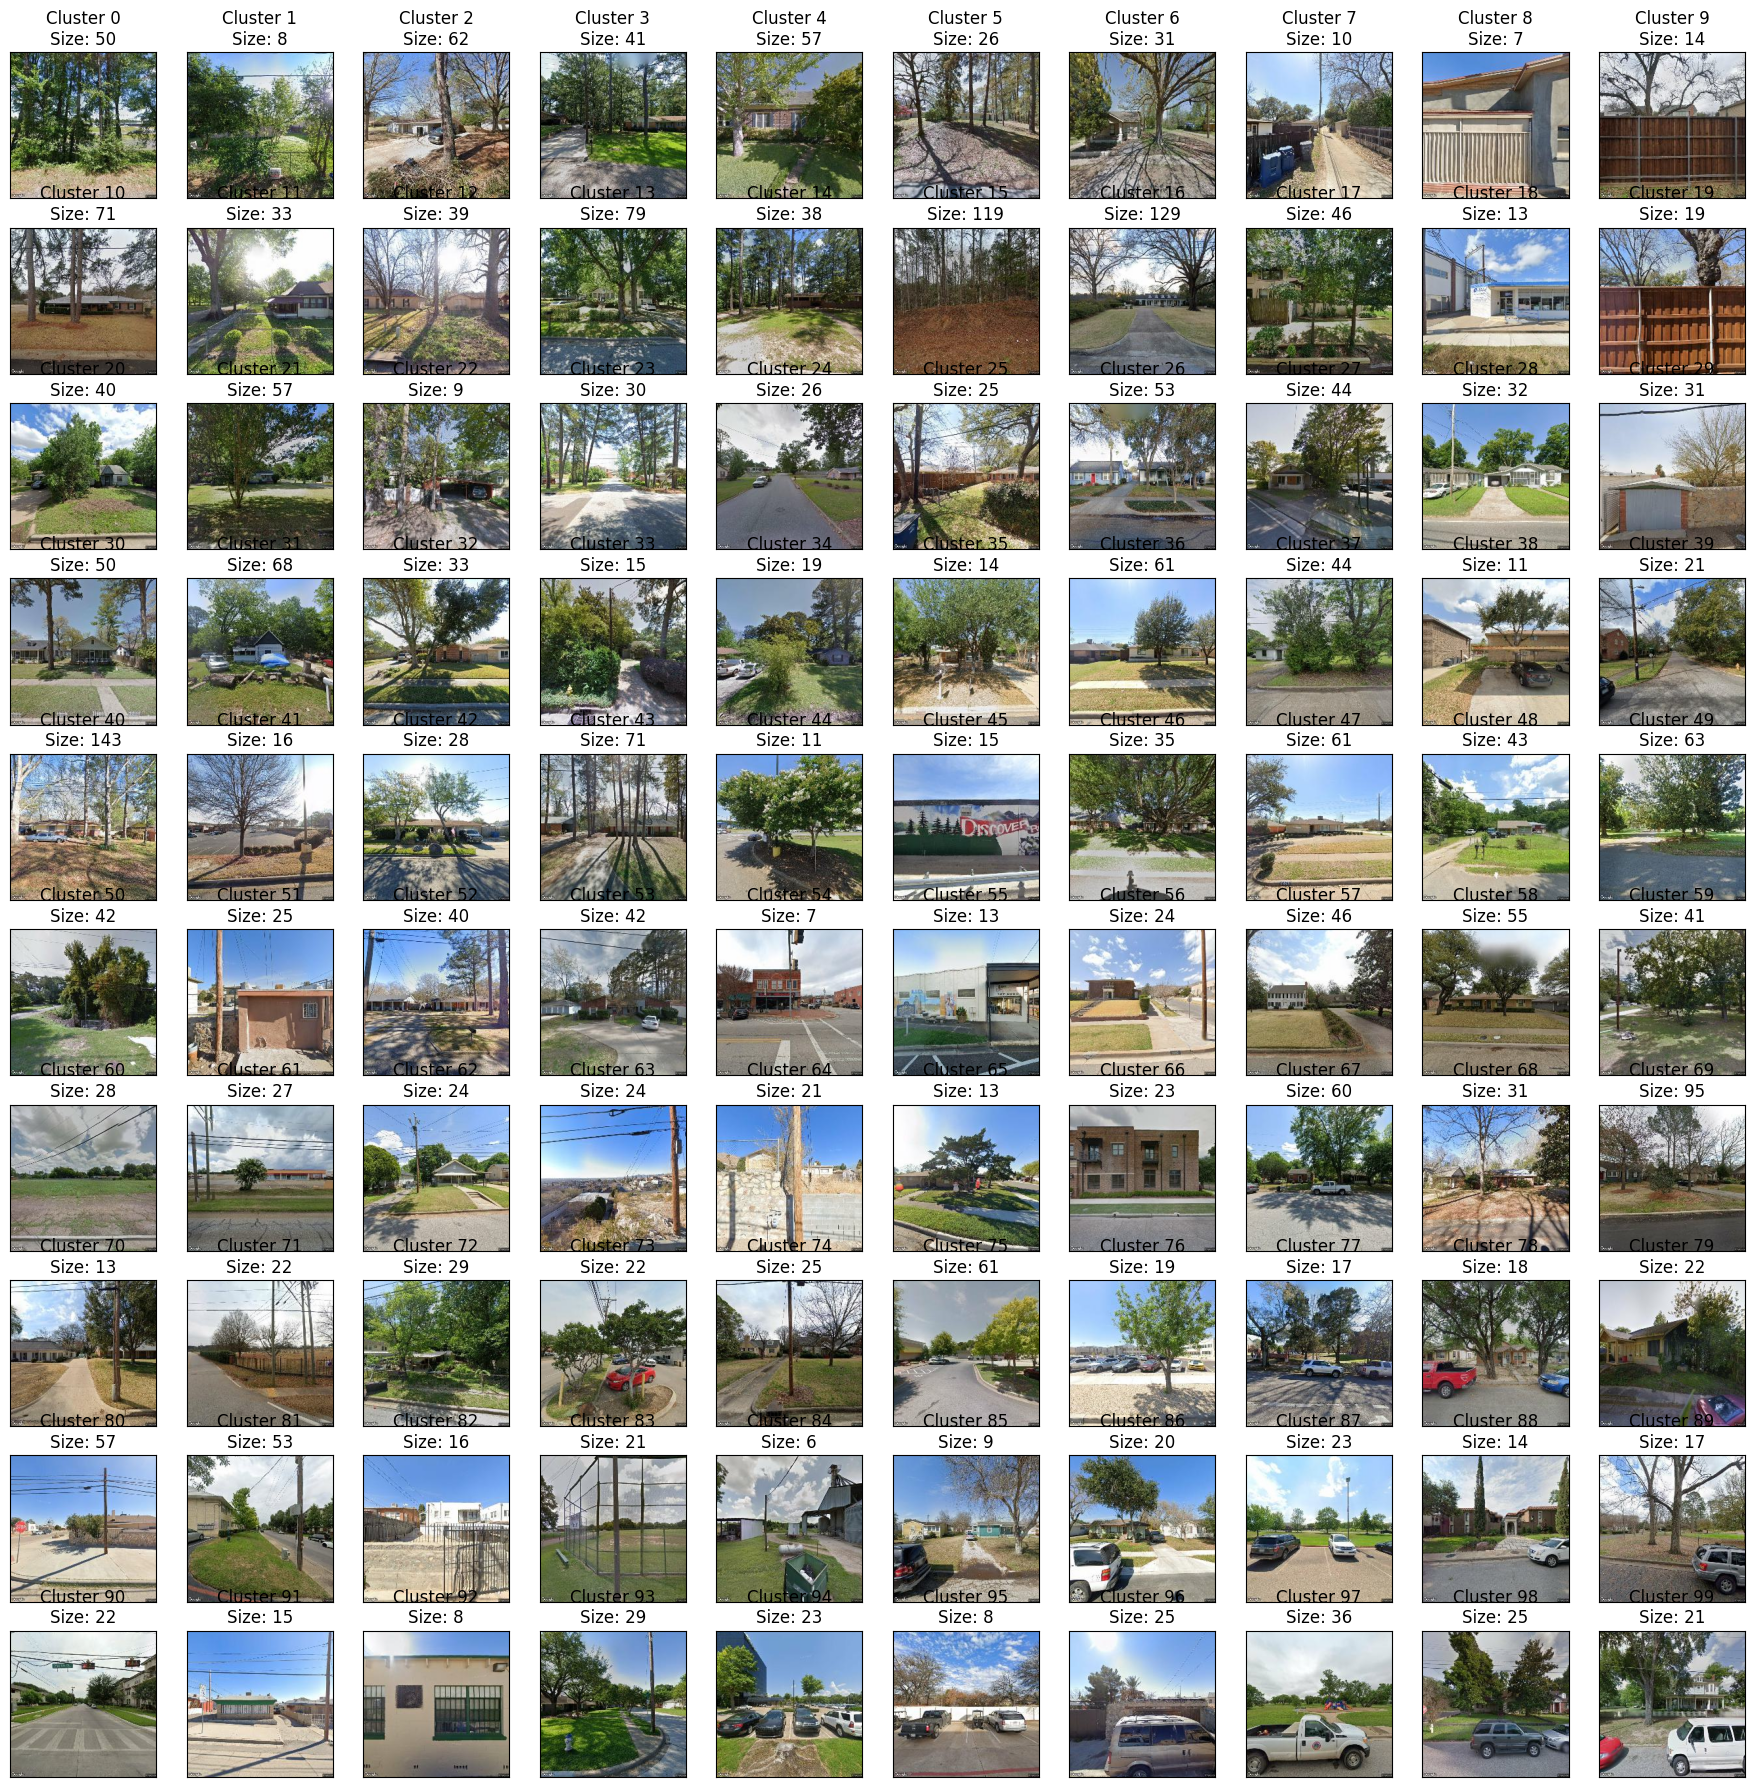

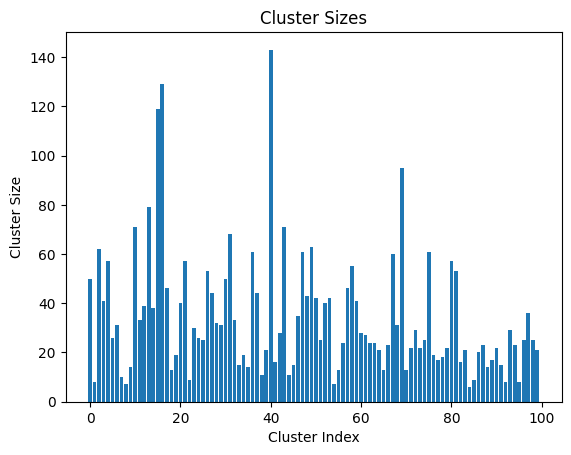

In [8]:
# Create a figure with 10x10 subplots
dpi = 100
subplot_size = 224
figsize = (m * subplot_size / dpi, m * subplot_size / dpi)

# Create a figure with 10x10 subplots
fig, axes = plt.subplots(m, m, figsize=figsize)

# Create a list to keep track of cluster sizes
cluster_sizes = []

# Plot each image in the 10x10 grid
for i in range(m):
    for j in range(m):
        # Get the index of the image to plot
        index = i * m + j
        bmu_images = filenames[(bmu_indices[:, 0] == i) & (bmu_indices[:, 1] == j)]

        # Append cluster size to the list
        cluster_sizes.append(len(bmu_images))

        # Plot the first image in the cluster (you can customize this)
        if len(bmu_images) > 0:
            try:
              ###############################################################################################
                img = Image.open('/content/drive/MyDrive/Colab Notebooks/streetview/' + bmu_images[0])
              ###############################################################################################
                axes[i, j].imshow(img)
            except Exception as e:
                print(f"Error loading image {bmu_images[0]}: {e}")
                axes[i, j].text(0.5, 0.5, "Error", ha="center", va="center")
        else:
            # In case of empty clusters, you can display a placeholder or a message
            axes[i, j].text(0.5, 0.5, "Empty Cluster", ha="center", va="center")

        # Add a title with cluster index and size
        axes[i, j].set_title(f'Cluster {index}\nSize: {len(bmu_images)}')

        # Remove the axis ticks
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Save the figure to a file
plt.savefig('grid_som_10x10.png')

# Visualize cluster sizes
plt.figure()
plt.bar(range(m * m), cluster_sizes)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes')
plt.savefig('cluster_sizes.png')

plt.show()


# **Display 25  images belonging to the target cluster.**

['32.88106823307944,-85.17222685905465_right.jpg', '32.83718570629178,-96.75277704477662_left.jpg', '32.34844848247124,-86.27127287220466_right.jpg', '32.52131742988409,-84.95819286528413_right_1.jpg', '32.35205383884032,-86.28555430031149_right.jpg', '32.346683316947,-86.29656075923948_left.jpg', '31.87977066176138,-106.4127465209835_left.jpg', '32.52655514842471,-92.0919485160616_left.jpg', '33.49208156443444,-88.42254940401699_right.jpg', '33.50055997892839,-88.42417077366409_right.jpg', '32.83630084685438,-96.75375395439286_left.jpg', '31.34074847046343,-94.71061320385346_right.jpg', '32.84742553685672,-96.76585603226135_right.jpg', '32.51322576911065,-92.10118652935257_right.jpg', '31.77449163688901,-106.4556079427063_right.jpg', '32.5044282639757,-84.98416169305719_left.jpg', '35.37677023229598,-94.40691945373327_left.jpg', '32.35798044122249,-86.27623092132093_left_1.jpg', '32.82564365823531,-96.76579051106542_left.jpg', '33.82311884161687,-88.54435496348395_left.jpg', '32.83666

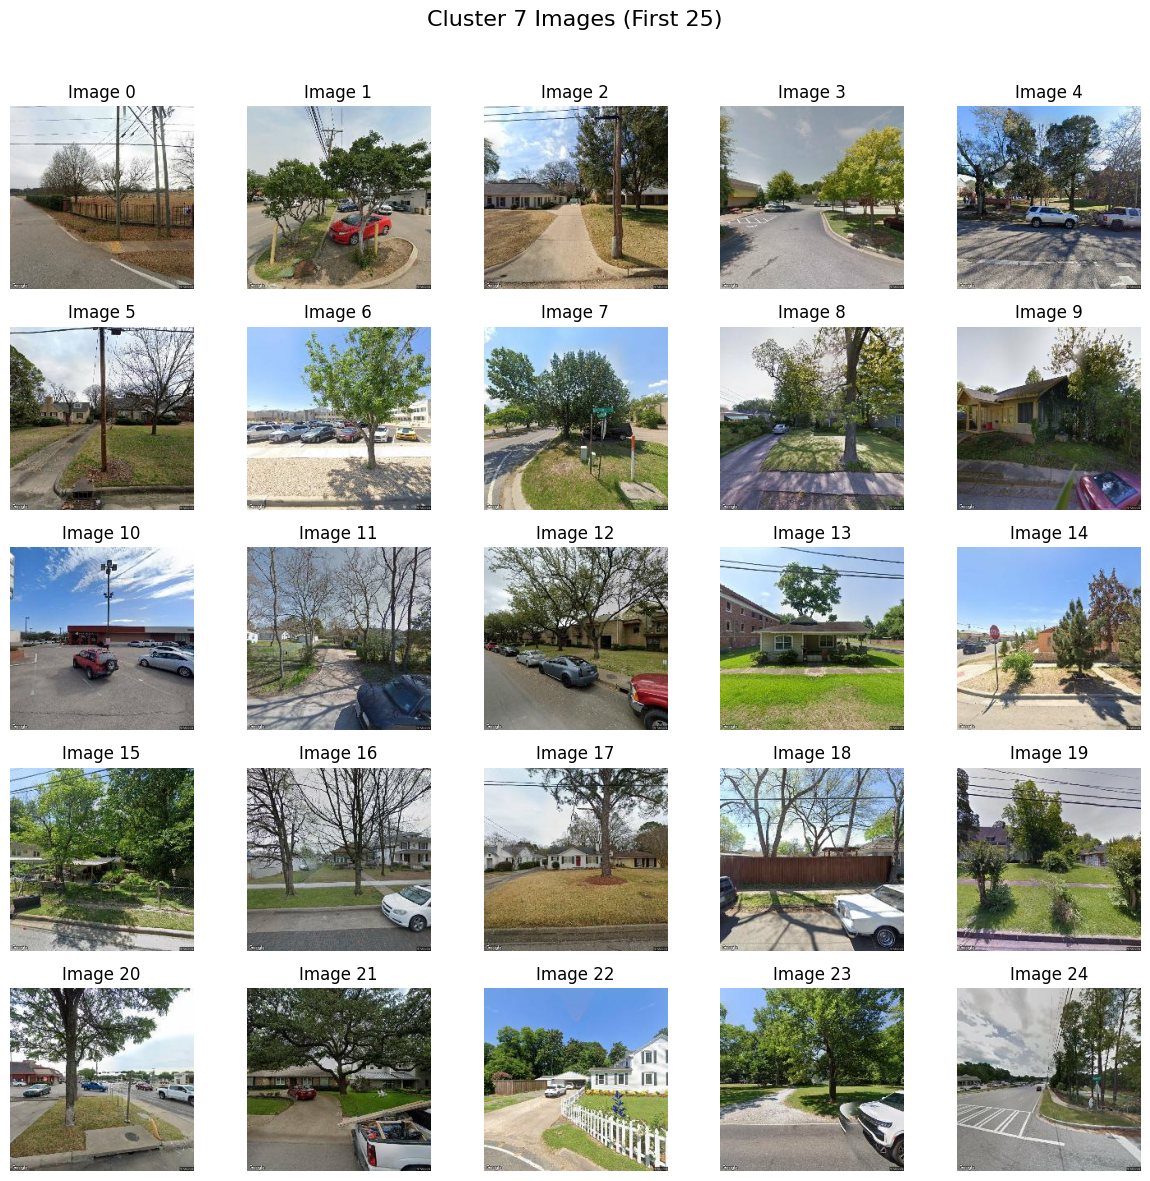

In [11]:
##############################################################################
# Target cluster index to display
target_cluster = 7  # Change this to the cluster index you want to display
##############################################################################



# Find all images belonging to the target cluster
cluster_images = [filenames[i] for i in range(len(bmu_indices)) if bmu_indices[i][0] == target_cluster]


##############################################################################
# Limit the display to the first 25 images (you can adjust this number)
num_images_to_display = 25
##############################################################################
cluster_images = cluster_images[:num_images_to_display]

# Create a figure to display cluster images
plt.figure(figsize=(12, 12))
plt.suptitle(f"Cluster {target_cluster} Images (First {num_images_to_display})", fontsize=16)

# Iterate through and display the first 25 images
for i in range(len(cluster_images)):
    plt.subplot(5, 5, i + 1)
    try:
        img = Image.open('/content/drive/MyDrive/Colab Notebooks/streetview/' + cluster_images[i])
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {cluster_images[i]}: {e}")
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
